Attitude and Position Integration: https://www.vectornav.com/resources/inertial-navigation-primer/math-fundamentals/math-coning

## Position Determination from YPR (Delta Velocity method)

In [1]:
import pandas as pd
import numpy as np
from math import sin, cos, pi, atan2, asin
import matplotlib.pyplot as plt
from scipy import integrate

from get_YPR_matrix import convert_YPR_fixed_frame

In [2]:
def readCSV(filename):
    with open(filename) as csvDataFile:
        # Read file as csv
        df = pd.read_csv(csvDataFile)
    return df


def nasa_pres(P, P0=101.29, T0=288.08):
    T = T0*((P / P0)**(1 / 5.256)) - 273.1
    h = (T-15.04)/(-0.00649)
    return h


################## CONSTANTS ##################
# gravity
g = 9.81  # m/s^2
# m to ft
ft = 3.2884  # ft/m

################## DATA FRAME ##################
datafile = '../Fullscale21.csv'
fields = ['Timestamp', 'Pres',
  'dTheta X', 'dTheta Y', 'dTheta Z',
  'Roll', 'Pitch', 'Yaw',
  'dVel X', 'dVel Y', 'dVel Z',
  'Qtn[0]', 'Qtn[1]', 'Qtn[2]', 'Qtn[3]',
  'LinearAccelNed X', 'LinearAccelNed Y', 'LinearAccelNed Z'
  ]

df = pd.read_csv(datafile, skipinitialspace=True, usecols=fields)

################## INIT VECTORS ##################
all_time = df['Timestamp'].values

tdata = all_time
tdata = tdata - all_time[0]

In [3]:
ax_vn = df['LinearAccelNed X'] * ft
ay_vn = df['LinearAccelNed Y'] * ft
az_vn = df['LinearAccelNed Z'] * -ft

vx_vn, vy_vn, vz_vn = np.zeros(len(ax_vn)),np.zeros(len(ay_vn)), np.zeros(len(az_vn))
x_vn, y_vn, z_vn = np.zeros(len(ax_vn)),np.zeros(len(ay_vn)), np.zeros(len(az_vn))
dt = tdata[1]

vx_vn = integrate.cumtrapz(ax_vn, tdata, initial=0)
vy_vn = integrate.cumtrapz(ay_vn, tdata, initial=0)
vz_vn = integrate.cumtrapz(az_vn, tdata, initial=0)

x_vn = integrate.cumtrapz(vx_vn, tdata, initial=0)
y_vn = integrate.cumtrapz(vy_vn, tdata, initial=0)
z_vn = integrate.cumtrapz(vz_vn, tdata, initial=0)

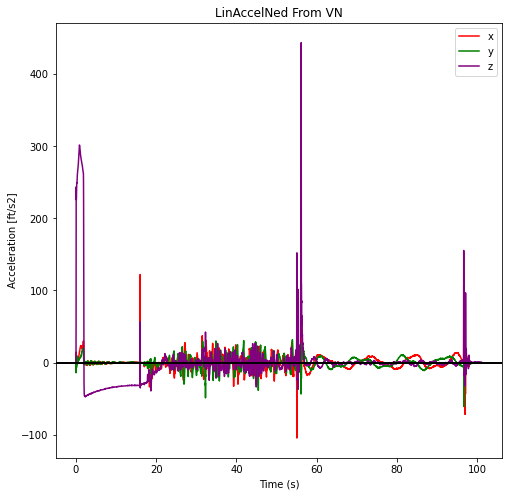

In [4]:
fig1 = plt.figure(1, figsize=(8,8))
ax = plt.subplot(111)
l2 = ax.plot(tdata, ax_vn, color='red', label='x')
l3 = ax.plot(tdata, ay_vn, color='green', label='y')
l4 = ax.plot(tdata, az_vn, color='purple', label='z')
l5 = plt.axhline(y=0, color='black', linewidth=2)
ax.set_title("LinAccelNed From VN")
ax.set_xlabel('Time (s)')
ax.set_ylabel("Acceleration [ft/s2]")
ax.legend()
plt.show()

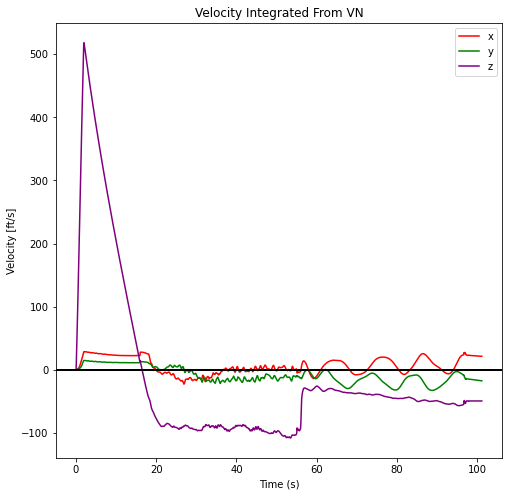

In [5]:
fig1 = plt.figure(1, figsize=(8,8))
ax = plt.subplot(111)
l2 = ax.plot(tdata, vx_vn, color='red', label='x')
l3 = ax.plot(tdata, vy_vn, color='green', label='y')
l4 = ax.plot(tdata, vz_vn, color='purple', label='z')
l5 = plt.axhline(y=0, color='black', linewidth=2)
ax.set_title("Velocity Integrated From VN")
ax.set_xlabel('Time (s)')
ax.set_ylabel("Velocity [ft/s]")
ax.legend()
plt.show()

Vanilla numerical integration:
- We don't expect this to work because the IMU acceleration data is pretty biased.  When sitting on the pad the acceleration is not zero, sometimes over 1 m/s

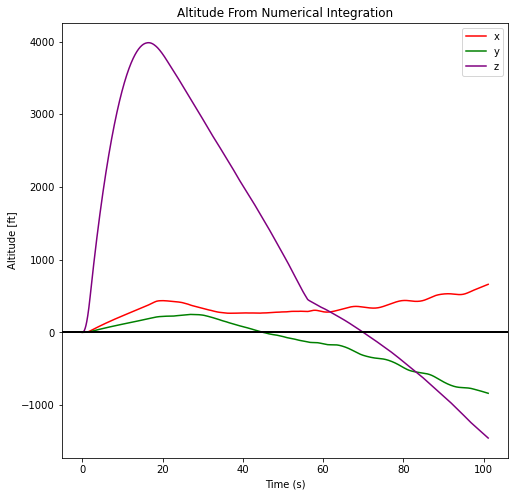

In [6]:
fig1 = plt.figure(1, figsize=(8,8))
# Just the Displacement:
ax = plt.subplot(111)
#l1 = ax.plot(tdata, altitude_NASA_pres, color='blue', label='NASA Pressure')
l2 = ax.plot(tdata, x_vn, color='red', label='x')
l3 = ax.plot(tdata, y_vn, color='green', label='y')
l4 = ax.plot(tdata, z_vn, color='purple', label='z')
l5 = plt.axhline(y=0, color='black', linewidth=2)
ax.set_title("Altitude From Numerical Integration")
ax.set_xlabel('Time (s)')
ax.set_ylabel("Altitude [ft]")
ax.legend()
plt.show()

## Using Delta Velocity

In [7]:
# dVelocity [m/s]
dvx = np.array(df['dVel X'])
dvy = np.array(df['dVel Y'])
dvz = np.array(df['dVel Z'])

dVel = np.dstack((dvx, dvy, dvz))
dVel = np.reshape(dVel, (dVel.shape[2], dVel.shape[1]))
dVel0 = dVel[:,0]
assert dVel0[0]==dvx[0]
print(f"dVel0 = {dVel0}")

dVel0 = [ 0.0018463 -0.0236734 -0.0676847]


Should be able to get the YPR from the quaternion, which is theoretically not based on the magnetometer

In [8]:
# Quaternion
# The estimated attitude quaternion: last term is the scalar value
# The attitude is given as the body frame wrt the local North East Down (NED) frame
qx = np.array(df['Qtn[0]'])
qy = np.array(df['Qtn[1]'])
qz = np.array(df['Qtn[2]'])
qw = np.array(df['Qtn[3]'])

quats = np.dstack((qx, qy, qz, qw))
quats = np.reshape(quats, (quats.shape[2], quats.shape[1]))
quat0 = np.reshape(quats[:,0], (4,1))
print(f"quat0 = {quat0}")

quat0 = [[0.343931 ]
 [0.119303 ]
 [0.539867 ]
 [0.0610635]]


In [9]:
def quat2ypr(quat):
    # Figure out if this returns an answer is rads or deg
    # Presumably rads
    
    q1 = quat[0] #[0]  # x
    q2 = quat[1] #[0]  # y
    q3 = quat[2] #[0]  # z
    q0 = quat[3] #[0]  # w
    
    #yaw = atan2(pi/180 * (2.*(q1*q2 + q0*q3)), pi/180 * (q0*q0 + q1*q1 - q2*q2 - q3*q3))
    #pitch = asin(pi/180 * (-2.*(q1*q3 - q0*q2)))
    #roll = atan2(pi/180 * 2.0*(q2*q3 + q0*q1), pi/180 * (q0*q0 - q1*q1 - q2*q2 + q3*q3))
    
    yaw = atan2((2.*(q1*q2 + q0*q3)), (q0*q0 + q1*q1 - q2*q2 - q3*q3))
    pitch = asin((-2.*(q1*q3 - q0*q2)))
    roll = atan2(2.*(q2*q3 + q0*q1), (q0*q0 - q1*q1 - q2*q2 + q3*q3))
    return np.array([yaw, pitch, roll])

I changed my mind and decided to use the raw yaw, pitch, and roll as measured by the VN.  Note that you get different results when you use this vs deriving them from the quaternion.  These results are slightly better but still not good.

In [10]:
L = quats.shape[1]

# Body frame YPR
# byaw, bpitch, broll = np.zeros(L), np.zeros(L), np.zeros(L)

'''
for idx, quat in enumerate(quats):
    bypr = quat2ypr(quat)
    byaw[idx], bpitch[idx], broll[idx] = bypr[0], bypr[1], bypr[2]
'''

byaw = df['Yaw'].values
bpitch = df['Pitch'].values
broll = df['Roll'].values

In [11]:
def make_rot_matrix(yaw, pitch, roll):
    Ry = np.array([[cos(pi/180*yaw), -sin(pi/180*yaw), 0],
                   [sin(pi/180*yaw), cos(pi/180*yaw), 0],
                   [0, 0, 1]])
    Rp = np.array([[cos(pi/180*pitch), 0, sin(pi/180*pitch)],
                   [0, 1, 0],
                   [-sin(pi/180*pitch), 0, cos(pi/180*pitch)]])
    Rr = np.array([[1, 0, 0],
                   [0, cos(pi/180*roll), -sin(pi/180*roll)],
                   [0, sin(pi/180*roll), cos(pi/180*roll)]]) 
    return np.matmul( np.matmul(Ry, Rp), Rr )

In [20]:
assert L == len(byaw)
v = np.zeros((3, L))
p = np.zeros((3, L))
g_vec = np.array([[0], [0], [9.81]])

for i in range(L):
    # Get the dVel at this instance, e.g. body frame
    bdv = np.reshape(dVel[:,i], (3, 1))
    
    # Convert body frame dVel to fixed world frame dVel
    R = make_rot_matrix(byaw[i], bpitch[i], broll[i])
    idv = np.matmul(R, bdv)
    
    # Correct for gravity, Coriolis term, and current velocity
    # CORIOLIS FORCE PRIMER
    # https://en.wikipedia.org/wiki/Coriolis_force
    # https://www.youtube.com/watch?v=kCbMKSZZO9w
    # Earth's Angular Rate: https://hypertextbook.com/facts/2002/JasonAtkins.shtml
    we = np.array([[0], [0], [7.27*10**(-5)]]) #rad/s
    # ^Rot is about the z axis.  Assuming the other values are 0
    
    # By default, the slices are 1D arrays. This makes them 2D arrays
    v_current = np.reshape(v[:, i], (3,1))
    p_current = np.reshape(p[:, i], (3,1))
    
    # Cross product of the Earth's angular rate (3x1) and the current velocity
    mcp = np.cross((2*we).reshape((3,)), v[:, i]).reshape((3,1))
    dvgc = dt*(g_vec - mcp)
    # ^dt is 0.025, from 40 Hz

    dvc = idv + dvgc

    # Iterate to define next velocity point
    v_new = v_current + dvc
    if i==(L-1):
        pass
    else:
        v[0, i+1], v[1, i+1], v[2, i+1] = v_new[0], v_new[1], v_new[2]

    # Iterate to define next position
    #dp[i+1] = p[i] + dt*vk + dt*dvc/2
    dp = p_current + dt*v_current + dt*dvc/2
    p_new = p_current + dp
    p[0, i], p[1, i], p[2, i] = p_new[0], p_new[1], p_new[2]

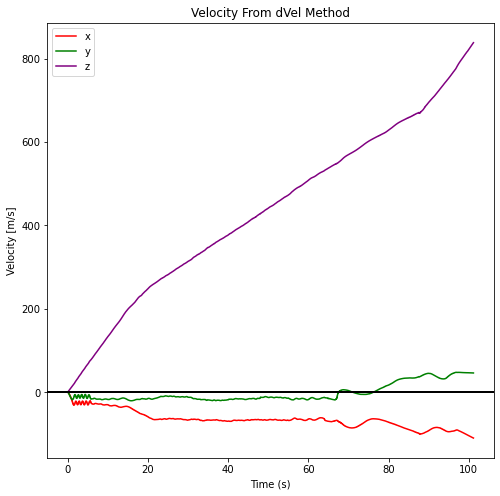

In [21]:
fig1 = plt.figure(1, figsize=(8,8))
ax = plt.subplot(111)
l2 = ax.plot(tdata, v[0,:], color='red', label='x')
l3 = ax.plot(tdata, v[1,:], color='green', label='y')
l4 = ax.plot(tdata, v[2,:], color='purple', label='z')
l5 = plt.axhline(y=0, color='black', linewidth=2)
ax.set_title("Velocity From dVel Method")
ax.set_xlabel('Time (s)')
ax.set_ylabel("Velocity [m/s]")
ax.legend()
plt.show()

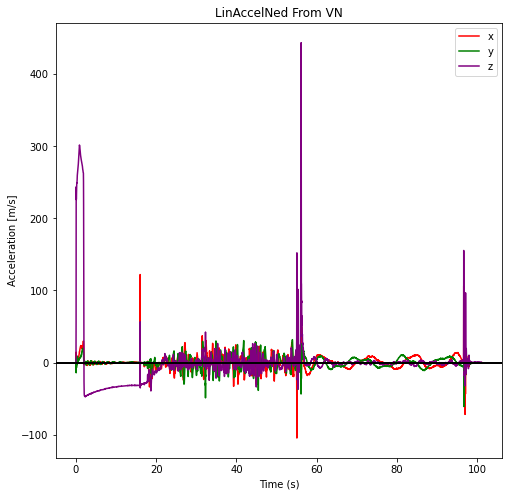

In [14]:
fig1 = plt.figure(1, figsize=(8,8))
ax = plt.subplot(111)
l2 = ax.plot(tdata, ax_vn, color='red', label='x')
l3 = ax.plot(tdata, ay_vn, color='green', label='y')
l4 = ax.plot(tdata, az_vn, color='purple', label='z')
l5 = plt.axhline(y=0, color='black', linewidth=2)
ax.set_title("LinAccelNed From VN")
ax.set_xlabel('Time (s)')
ax.set_ylabel("Acceleration [m/s]")
ax.legend()
plt.show()

## Preliminary Position Results 

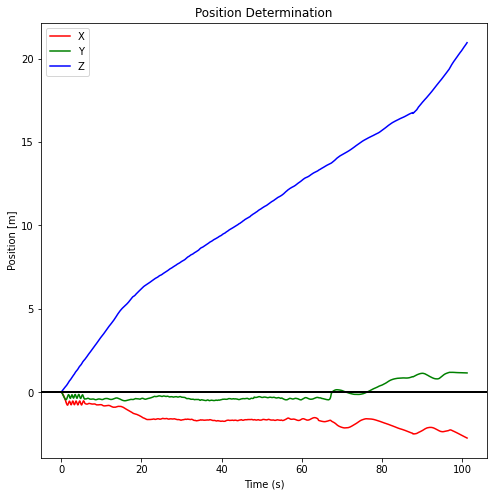

In [22]:
fig1 = plt.figure(1, figsize=(8,8))
ax = plt.subplot(111)
l1 = ax.plot(tdata, p[0,:], 'r', label='X')
l2 = ax.plot(tdata, p[1,:], 'g', label='Y')
l3 = ax.plot(tdata, p[2,:], 'b', label='Z')
l4 = plt.axhline(y=0, color='black', linewidth=2)
ax.set_title("Position Determination")
ax.set_xlabel('Time (s)')
ax.set_ylabel("Position [m]")
ax.legend()
plt.show()

## Results Comparisons for Velocity

In [16]:
dvx_sum = [sum(dvx[0:list(dvx).index(ele)]) for ele in dvx]
dvy_sum = [sum(dvy[0:list(dvy).index(ele)]) for ele in dvy]
dvz_sum = [sum(dvz[0:list(dvz).index(ele)]) for ele in dvz]

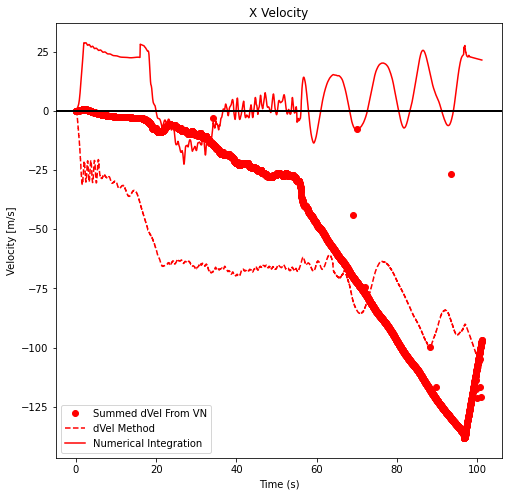

In [17]:
fig1 = plt.figure(1, figsize=(8,8))
ax = plt.subplot(111)
l1 = ax.plot(tdata, dvx_sum, 'ro', label='Summed dVel From VN')
l2 = ax.plot(tdata, v[0,:], '--r', label='dVel Method')
l3 = ax.plot(tdata, vx_vn, color='red', label='Numerical Integration')
l5 = plt.axhline(y=0, color='black', linewidth=2)
ax.set_title("X Velocity")
ax.set_xlabel('Time (s)')
ax.set_ylabel("Velocity [m/s]")
ax.legend()
plt.show()

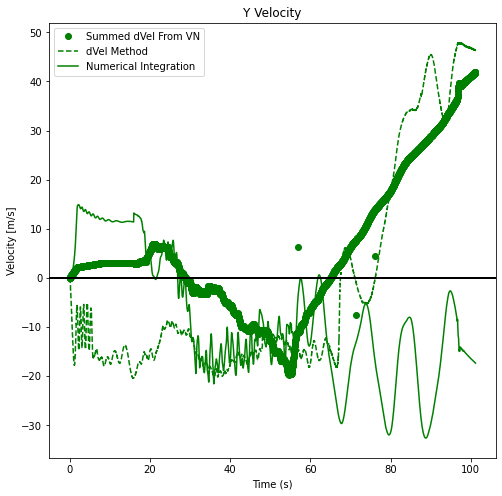

In [18]:
fig1 = plt.figure(1, figsize=(8,8))
ax = plt.subplot(111)
l1 = ax.plot(tdata, dvy_sum, 'go', label='Summed dVel From VN')
l2 = ax.plot(tdata, v[1,:], '--g', label='dVel Method')
l3 = ax.plot(tdata, vy_vn, color='green', label='Numerical Integration')
l5 = plt.axhline(y=0, color='black', linewidth=2)
ax.set_title("Y Velocity")
ax.set_xlabel('Time (s)')
ax.set_ylabel("Velocity [m/s]")
ax.legend()
plt.show()

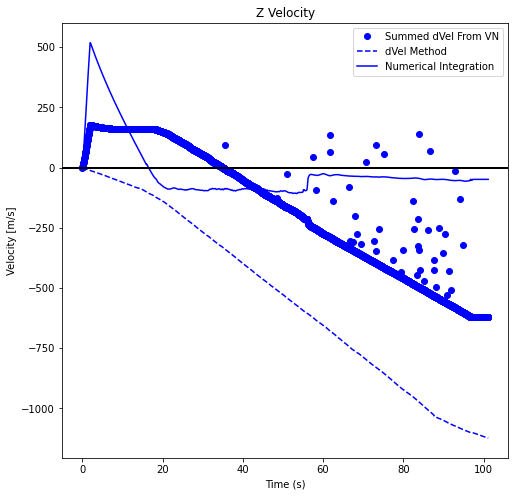

In [19]:
fig1 = plt.figure(1, figsize=(8,8))
ax = plt.subplot(111)
l1 = ax.plot(tdata, dvz_sum, 'bo', label='Summed dVel From VN')
l2 = ax.plot(tdata, v[2,:], '--b', label='dVel Method')
l3 = ax.plot(tdata, vz_vn, color='blue', label='Numerical Integration')
l5 = plt.axhline(y=0, color='black', linewidth=2)
ax.set_title("Z Velocity")
ax.set_xlabel('Time (s)')
ax.set_ylabel("Velocity [m/s]")
ax.legend()
plt.show()